In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.getcwd()

'/home/mridula/Projects/WIML/notebooks'

In [2]:
import argparse
from pathlib import Path
import json
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import torch
from deep_miml.cifar_bags import get_train_val_split_data, MIMLBagsData, collate_fn
from deep_miml.models import Average, Attention
from deep_miml.utils import precision_recall_helper, get_avg_batch_precision_recall_at_k



def test_multi_instance_model(model, device, dataloader):
    model.eval()
    batch_apk_list = []
    batch_ark_list = []
    with torch.no_grad():

        for inputs, sizes, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            sizes = sizes.to(device)
            labels = labels.to(device)
            
            if inputs.shape[0] == 0:
                # Checking batch_size >1
                continue
            category_type_logits = model(inputs, sizes)
            batch_apk = [get_avg_batch_precision_recall_at_k(
                                         labels.detach().cpu().tolist(),
                                         category_type_logits.detach().cpu().tolist(), k)[0] for k in range(1,7)]
            batch_ark = [get_avg_batch_precision_recall_at_k(
                                         labels.detach().cpu().tolist(),
                                         category_type_logits.detach().cpu().tolist(), k)[1] for k in range(1,7)]
            batch_apk_list.append(batch_apk)
            batch_ark_list.append(batch_ark)
        test_apk = np.around(np.mean(batch_apk_list, axis=0),3)
        test_ark = np.around(np.mean(batch_ark_list, axis=0),3)
    results = {}
    results['precision_at'] = {k+1: v for k, v in
                               dict(enumerate(test_apk)).items()}
    results['recall_at'] = {k+1: v for k, v in
                            dict(enumerate(test_ark)).items()}
    return results

/home/mridula/Projects/WIML/notebooks


In [12]:
data_file_path = '../data/miml_test_data_5000.pt'
image_datasets = torch.load(data_file_path)

# Create training and validation dataloaders
dataloader = torch.utils.data.DataLoader(image_datasets['test'],
                                         batch_size= 64,
                                         shuffle=False,
                                         num_workers= 4,
                                         collate_fn=collate_fn)

In [13]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


dfs = []
for m_n in ['resnet18', 'resnet34', 'resnet50']:
    for m_t in ['avg', 'attention']:
        file_path = f"../results_rs/cifar10_{m_n}_{m_t}_pretrained_True.pt"
        model = torch.load(file_path)

        # model = torch.load(model_path) #, map_location=torch.device("cpu"))
        model.to(device)

        res = test_multi_instance_model(model, device, dataloader)

        res_df = pd.DataFrame(res)
        m_t = 'mean_pool' if m_t == 'avg' else m_t
        res_df['model_name'] = m_n 
        res_df['model_type'] = m_t
        


        dfs.append(res_df)
dfs = pd.concat(dfs)
print(dfs.columns, '\n', dfs)
   

100%|██████████| 79/79 [00:09<00:00,  8.51it/s]

Index(['precision_at', 'recall_at', 'model_name', 'model_type'], dtype='object') 
    precision_at  recall_at model_name model_type
1         0.950      0.476   resnet18  mean_pool
2         0.819      0.729   resnet18  mean_pool
3         0.695      0.868   resnet18  mean_pool
4         0.580      0.938   resnet18  mean_pool
5         0.481      0.964   resnet18  mean_pool
6         0.408      0.976   resnet18  mean_pool
1         0.947      0.476   resnet18  attention
2         0.816      0.728   resnet18  attention
3         0.695      0.872   resnet18  attention
4         0.580      0.940   resnet18  attention
5         0.481      0.966   resnet18  attention
6         0.409      0.979   resnet18  attention
1         0.960      0.484   resnet34  mean_pool
2         0.827      0.740   resnet34  mean_pool
3         0.704      0.881   resnet34  mean_pool
4         0.587      0.949   resnet34  mean_pool
5         0.484      0.971   resnet34  mean_pool
6         0.410      0.983   resnet

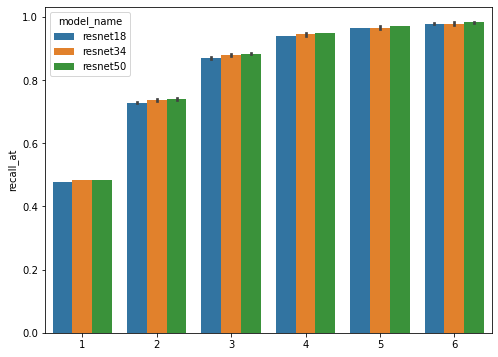

In [14]:
plt.rcParams["figure.figsize"] = (8,6)
sns.barplot(x=dfs.index, y="recall_at", hue="model_name", data=dfs)

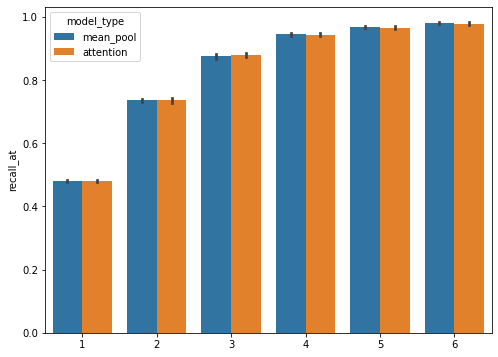

In [15]:
plt.rcParams["figure.figsize"] = (8,6)
sns.barplot(x=dfs.index, y="recall_at", hue="model_type", data=dfs)

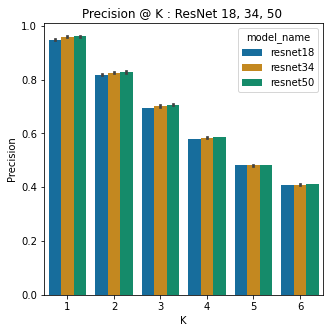

In [35]:
plt.rcParams["figure.figsize"] = (5,5)
ax = sns.barplot(x=dfs.index, y="precision_at", hue="model_name", data=dfs, palette='colorblind')
ax.set(xlabel='K', ylabel='Precision', title = "Precision @ K : ResNet 18, 34, 50 ");



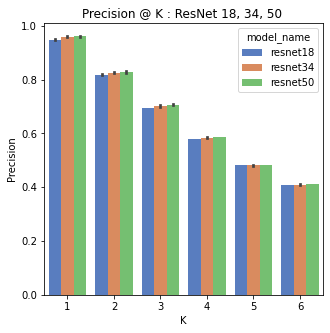

In [44]:
plt.rcParams["figure.figsize"] = (5,5)
ax = sns.barplot(x=dfs.index, y="precision_at", hue="model_name", data=dfs, palette='muted')
ax.set(xlabel='K', ylabel='Precision', title = "Precision @ K : ResNet 18, 34, 50 ");
plt.savefig('../results_rs/precision_resnets.pdf')


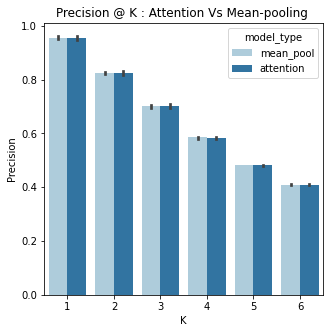

In [45]:
plt.rcParams["figure.figsize"] = (5,5)
sns.color_palette("Set2")
ax=sns.barplot(x=dfs.index, y="precision_at", hue="model_type", data=dfs,palette='Paired')
ax.set(xlabel='K', ylabel='Precision', title = "Precision @ K : Attention Vs Mean-pooling ");
plt.savefig('../results_rs/precision_model_type.pdf')



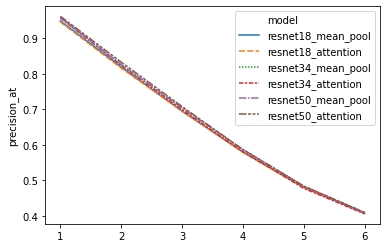

In [8]:
sns.lineplot(data=dfs, x=dfs.index, y="precision_at", hue="model", style="model")
# plt.savefig('../results/example_plot.pdf')



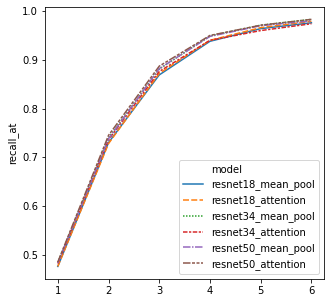

In [9]:
plt.rcParams["figure.figsize"] = (5,5)
sns.lineplot(data=dfs, x=dfs.index, y="recall_at", hue="model", style="model")

In [4]:


path = ''
dfs = []
for m_n in ['resnet18', 'resnet34']:
    for m_t in ['avg', 'attention']:
        file_path = '../results/results_'+m_n+'_'+m_t+'_miml_data20000.json'
        with open(file_path) as f:
            data = json.load(f)

            data_df = pd.DataFrame(data)


            data_df['model'] = m_n + '_' + m_t
            dfs.append(data_df)


dfs = pd.concat(dfs)
print(dfs.columns, '\n', dfs)



Index(['precision_at', 'recall_at', 'model'], dtype='object') 
    precision_at  recall_at               model
1         0.951      0.500        resnet18_avg
2         0.812      0.750        resnet18_avg
3         0.683      0.876        resnet18_avg
4         0.566      0.937        resnet18_avg
5         0.466      0.956        resnet18_avg
6         0.397      0.973        resnet18_avg
1         0.950      0.496  resnet18_attention
2         0.804      0.741  resnet18_attention
3         0.678      0.872  resnet18_attention
4         0.568      0.939  resnet18_attention
5         0.473      0.967  resnet18_attention
6         0.404      0.985  resnet18_attention
1         0.946      0.494        resnet34_avg
2         0.809      0.742        resnet34_avg
3         0.690      0.885        resnet34_avg
4         0.573      0.946        resnet34_avg
5         0.473      0.969        resnet34_avg
6         0.402      0.982        resnet34_avg
1         0.963      0.507  resnet34_attent